In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.under_sampling import NearMiss
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, concatenate
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel("./energy_demand.xlsx")
df.head()

,Date,Hour,load,T
0,2012-01-01,0,2872.0,30.666667
1,2012-01-01,1,2698.0,32.000000
2,2012-01-01,2,2558.0,32.666667
3,2012-01-01,3,2444.0,30.000000
4,2012-01-01,4,2402.0,31.000000


In [3]:
df.tail()

,Date,Hour,load,T
26300,2014-12-31,20,4012.0,18.000000
26301,2014-12-31,21,3856.0,16.666667
26302,2014-12-31,22,3671.0,17.000000
26303,2014-12-31,23,3499.0,15.333333
26304,2014-12-31,24,3345.0,15.333333


In [4]:
len(df.columns)

4

In [5]:
df.columns
df.dtypes

Date    datetime64[ns]
Hour             int64
load           float64
T              float64
dtype: object

In [6]:
df.shape

(26305, 4)

In [7]:
df.size

105220

In [8]:
df.min()

Date    2012-01-01 00:00:00
Hour                      0
load                 1979.0
T                -13.666667
dtype: object

In [9]:
df.max()

Date    2014-12-31 00:00:00
Hour                     24
load                 5224.0
T                      95.0
dtype: object

In [10]:
df.describe()

,Date,Hour,load,T
count,26305,26305.000000,26305.000000,26305.000000
mean,2013-07-01 11:30:01.710701312,12.499525,3303.752785,47.764988
min,2012-01-01 00:00:00,0.000000,1979.000000,-13.666667
25%,2012-09-30 00:00:00,6.000000,2867.000000,32.666667
50%,2013-07-01 00:00:00,12.000000,3364.000000,48.333333
75%,2014-04-01 00:00:00,18.000000,3690.000000,63.666667
max,2014-12-31 00:00:00,24.000000,5224.000000,95.000000
std,NaN,6.922616,564.574798,19.338062


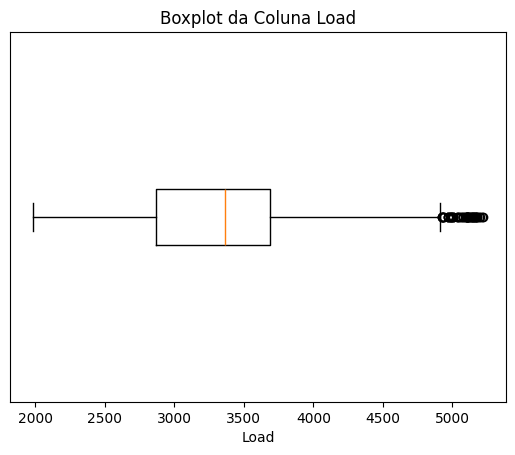

In [11]:
plt.boxplot(df['load'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Load')
plt.title('Boxplot da Coluna Load')
plt.yticks([])

# Mostra o boxplot
plt.show()

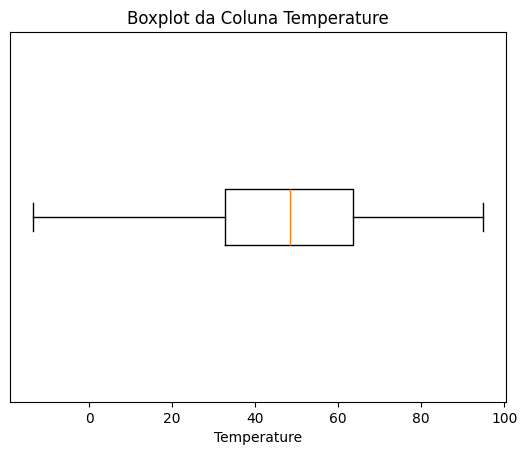

In [12]:
plt.boxplot(df['T'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Temperature')
plt.title('Boxplot da Coluna Temperature')
plt.yticks([])

# Mostra o boxplot
plt.show()

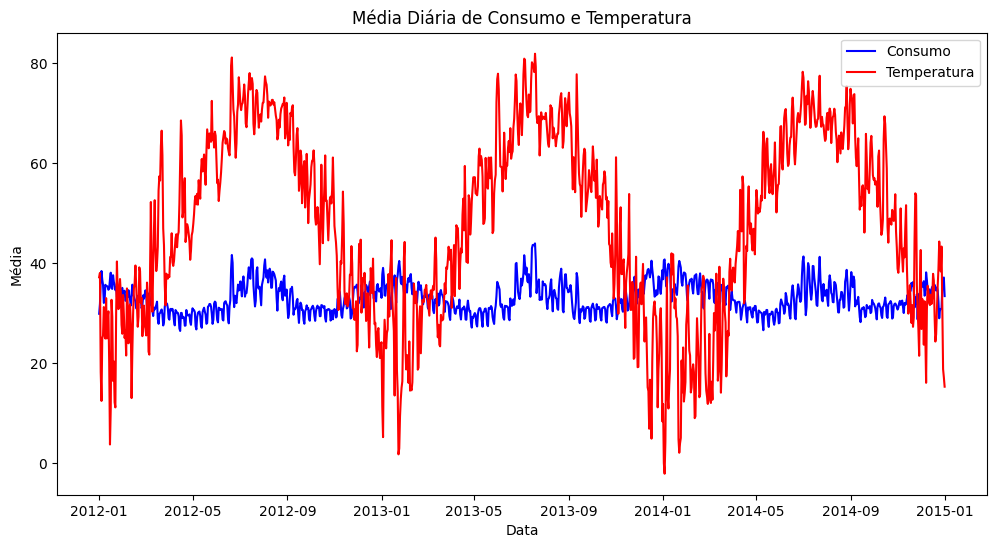

In [13]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Criar a coluna 'DateTime' combinando 'Date' e 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Remover 'Date' e 'Hour' se necessário
df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Configurar 'DateTime' como índice
df.set_index('DateTime', inplace=True)
# Agrupar por dia e calcular a média
daily_data = df.resample('D').mean()
daily_data['load'] = daily_data['load'] / 100

# Plotar o gráfico de dupla entrada
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_data.index, y=daily_data['load'], label='Consumo', color='blue')
sns.lineplot(x=daily_data.index, y=daily_data['T'], label='Temperatura', color='red')

plt.title('Média Diária de Consumo e Temperatura')
plt.xlabel('Data')
plt.ylabel('Média')
plt.legend()
plt.show()


In [14]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


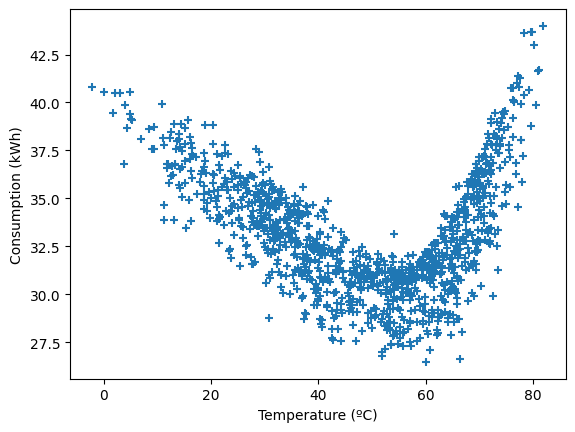

In [15]:
plt.scatter(daily_data['T'], daily_data['load'], marker='+')

plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.show()

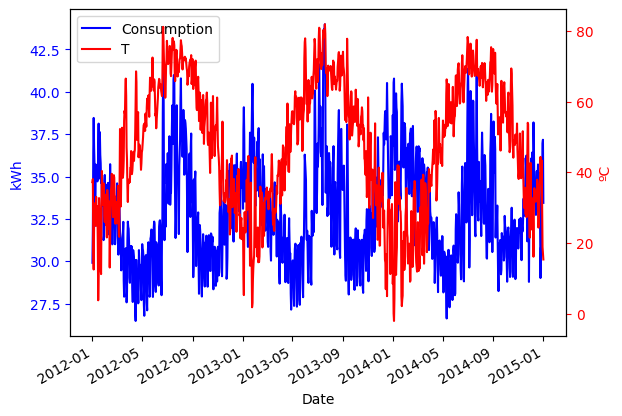

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(daily_data.index, daily_data['load'], 'b', label='Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('kWh', color='b')
ax1.tick_params('y', colors='b')

fig.autofmt_xdate()

ax2 = ax1.twinx()

ax2.plot(daily_data.index, daily_data['T'], 'r', label='T')
ax2.set_ylabel('ºC', color='r')
ax2.tick_params('y', colors='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()


In [17]:
df1=df
daily_data = df1.resample('24h').mean()
daily_data.head()


,load,T
DateTime,,
2012-01-01,2991.458333,37.208333
2012-01-02,3188.791667,38.083333
2012-01-03,3645.375000,18.291667
2012-01-04,3846.041667,12.486111
2012-01-05,3672.458333,25.000000


In [18]:
df.isna().sum()


load    0
T       0
dtype: int64

In [19]:
df.isnull().sum()

load    0
T       0
dtype: int64

In [20]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


In [21]:
load_series = df['load']

# Aplicar o teste ADF
result = adfuller(load_series)

# Exibir os resultados
print('ADF Statistic:', result[0])
print(f'p-value: {result[1]:.3e}')  # Formatando o p-value para notação científica com 3 casas decimais
print('Critical Values:', result[4])
#p-value mais baixo que 0.05 significa que se rejeita a hipotese nula, ou seja, admite-se que a série é estacionária

ADF Statistic: -10.406281746483792
p-value: 1.853e-18
Critical Values: {'1%': -3.430599093104556, '5%': -2.861650091842415, '10%': -2.566828598628419}


In [22]:
"""#df['hourofday'] = df.index.hour
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df['days_in_month'] = df.index.days_in_month
df['isWeekend'] = df.index.weekday // 5
df['isWeekend'] = df['isWeekend'].map({0: 'No', 1: 'Yes'})
df['dayoftheweek'] = df.index.dayofweek"""

"#df['hourofday'] = df.index.hour\ndf['quarter'] = df.index.quarter\ndf['month'] = df.index.month\ndf['year'] = df.index.year\ndf['dayofyear'] = df.index.dayofyear\ndf['dayofmonth'] = df.index.day\ndf['weekofyear'] = df.index.isocalendar().week\ndf['days_in_month'] = df.index.days_in_month\ndf['isWeekend'] = df.index.weekday // 5\ndf['isWeekend'] = df['isWeekend'].map({0: 'No', 1: 'Yes'})\ndf['dayoftheweek'] = df.index.dayofweek"

In [23]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


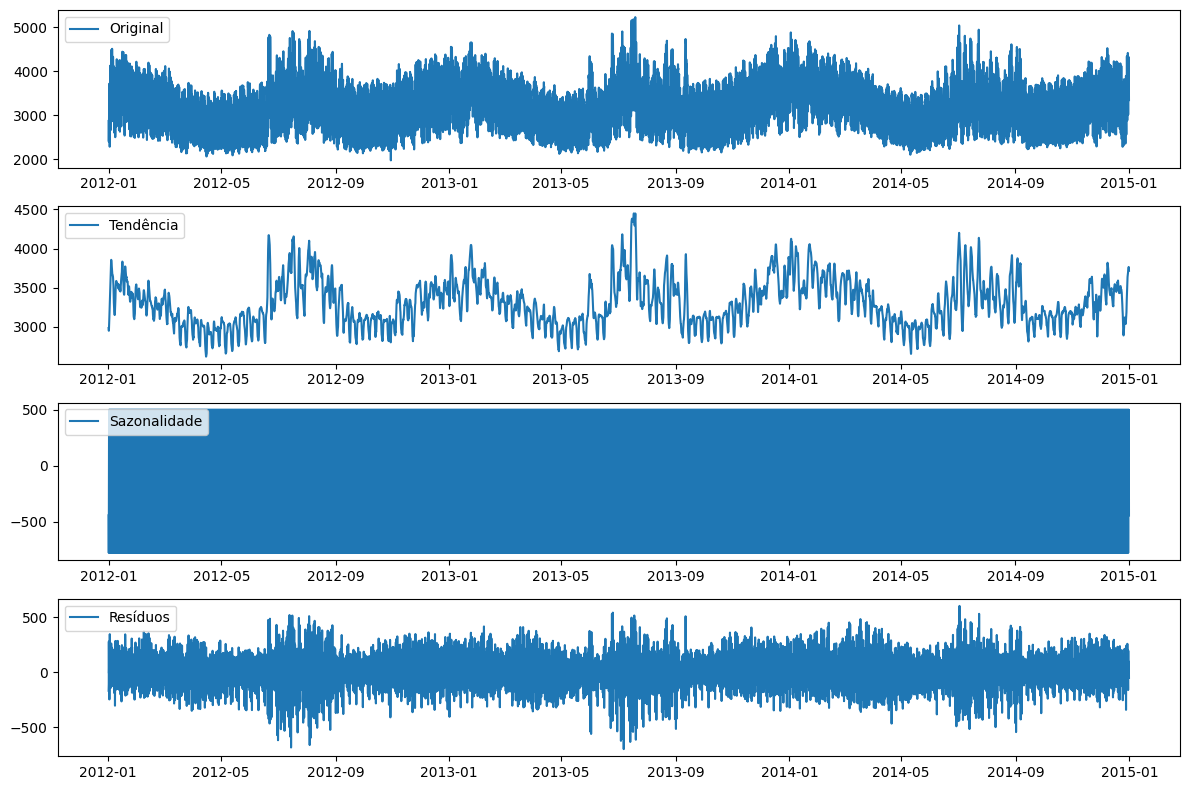

In [24]:

# Supondo que 'df' seja seu DataFrame com uma coluna chamada 'load'
load_series = df['load']

# Realizar a decomposição
result = seasonal_decompose(load_series, model='additive', period=24)  # O período aqui é assumido como 24 para dados horários

# Extrair as componentes
trend = result.trend
seasonal = result.seasonal
residuals = result.resid

# Plotar as componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(load_series, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residuals, label='Resíduos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

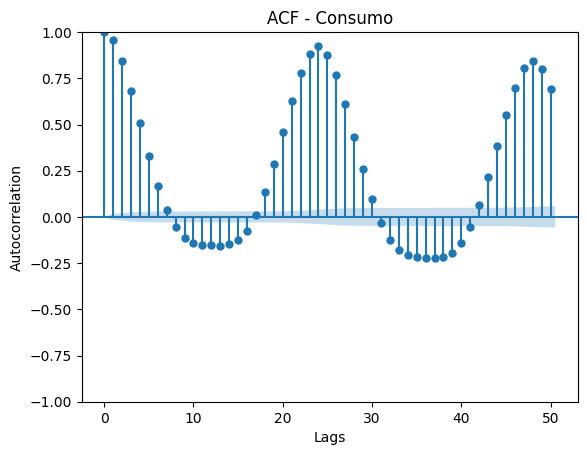

<Figure size 1200x600 with 0 Axes>

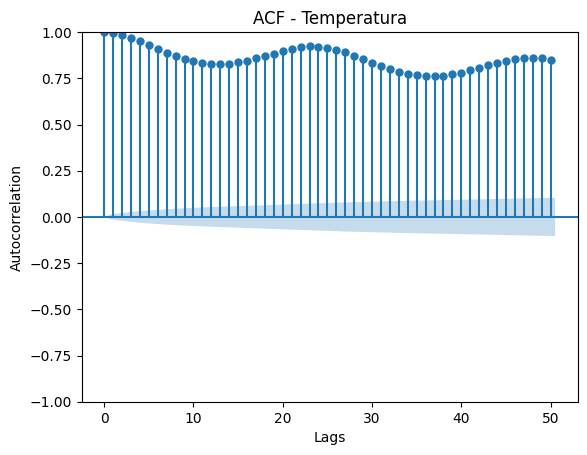

In [25]:

consumo_series = df['load']
temperatura_series = df['T']

plt.figure(figsize=(12, 6))
plot_acf(consumo_series, lags=50, title='ACF - Consumo')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(temperatura_series, lags=50, title='ACF - Temperatura')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
#correlaçao existe até 10 dias


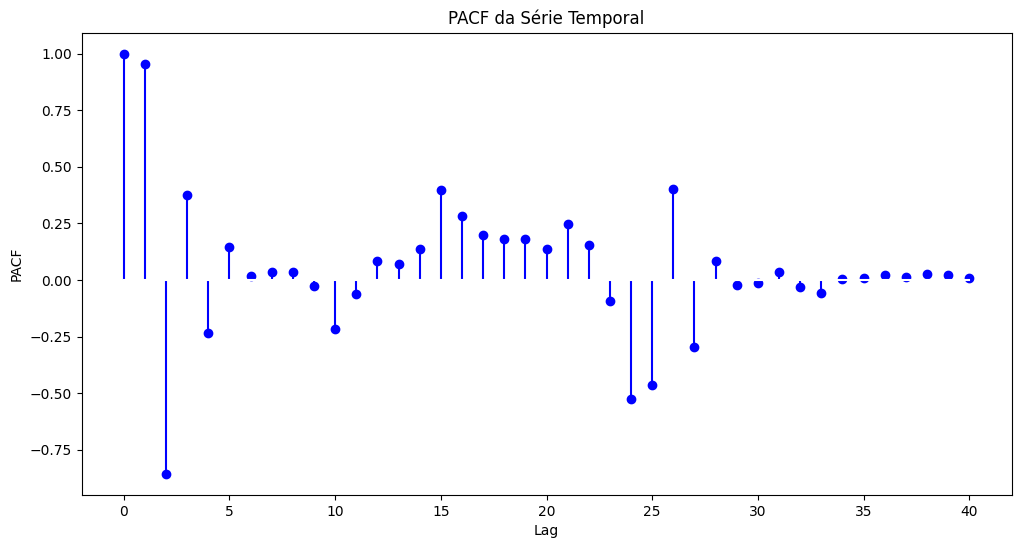

In [26]:
pacf_values, pacf_conf_int = sm.tsa.pacf(df['load'], nlags=40, alpha=0.05)

# Plotar a PACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, linefmt='b-', markerfmt='bo', basefmt='w-')
plt.title('PACF da Série Temporal')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [27]:
# Criar cópias atrasadas das séries temporais
lag_consumo = 1  # Defina o lag desejado
lag_temperatura = 0  # Pode ajustar conforme necessário

consumo_shifted = consumo_series.shift(lag_consumo)
temperatura_shifted = temperatura_series.shift(lag_temperatura)

# Calcular a correlação entre as séries temporais atrasadas
correlation = consumo_shifted.corr(temperatura_shifted)

print(f"Correlação entre Consumo (lag={lag_consumo}) e Temperatura (lag={lag_temperatura}): {correlation}")


Correlação entre Consumo (lag=1) e Temperatura (lag=0): 0.08164031232672768


In [28]:
"""

variavel = 10
resultado = variavel * 2
print(resultado)
d = 0
D = 0
s = 24

def evaluate_sarima(order, seasonal_order, data):
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        aic = results.aic
        return aic
    except:
        return float('inf')  # Return a large value for combinations that fail

def grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):
    best_aic = float('inf')
    best_params = None

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))

    for param_set in param_combinations:
        order = (param_set[0], d, param_set[1])
        seasonal_order = (param_set[2], D, param_set[3], s)
        print(param_set)
        aic = evaluate_sarima(order, seasonal_order, data)

        if aic < best_aic:
            best_aic = aic
            best_params = param_set

    return best_params, best_aic

# Example usage:
# Define the ranges for your parameters
p_values = range(1, 4)
q_values = range(1, 4)
P_values = range(1, 4)
Q_values = range(1, 4)

# Perform grid search
best_params, best_aic = grid_search_sarima(df['load'], p_values, d, q_values, P_values, D, Q_values, s)

print("Best Parameters:", best_params)
print("Best AIC:", best_aic)
"""






'\n\n\n# Código abaixo\nvariavel = 10\nresultado = variavel * 2\nprint(resultado)\nd = 0\nD = 0\ns = 24\n\ndef evaluate_sarima(order, seasonal_order, data):\n    try:\n        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)\n        results = model.fit(disp=False)\n        aic = results.aic\n        return aic\n    except:\n        return float(\'inf\')  # Return a large value for combinations that fail\n\ndef grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):\n    best_aic = float(\'inf\')\n    best_params = None\n\n    # Generate all combinations of parameters\n    param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))\n\n    for param_set in param_combinations:\n        order = (param_set[0], d, param_set[1])\n        seasonal_order = (param_set[2], D, param_set[3], s)\n        print(param_set)\n        aic = evaluate_sarima(order, seasonal_order, data)\n\n        if aic < best_aic:\n            best_aic = aic\

In [102]:
# Definir os melhores parâmetros obtidos
order = (2, 0, 3)
seasonal_order = (2, 0, 2, 24)
df_load = df['load']
train_size = len(df_load) - 168
train, test = df_load[:train_size], df[train_size:]
# Criar e ajustar o modelo SARIMA
model = SARIMAX(df['load'], order=order, seasonal_order=seasonal_order)
results = model.fit()


forecast_steps = 168  
forecast = results.get_forecast(steps=forecast_steps)
confidence_intervals= forecast.conf_int()
mse_sarima = ((test - forecast.predicted_mean) ** 2).mean()

In [30]:
"""predicted_values = forecast.predicted_mean
plt.plot(test.index, test["load"], label='Actual Data')
plt.plot(test.index, predicted_values, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.show()"""

'predicted_values = forecast.predicted_mean\nplt.plot(test.index, test["load"], label=\'Actual Data\')\nplt.plot(test.index, predicted_values, label=\'Predicted Data\')\nplt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color=\'k\', alpha=0.1, label=\'Confidence Intervals\')\nplt.legend()\nplt.show()'

In [104]:
p, d, q =2, 0, 2
P, D, Q, s = 3, 0, 2, 24

exog_variable = df['T']

sarimax_model_exog = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog_variable[:train_size])
sarimax_result_exog = sarimax_model_exog.fit(disp=False,method='powell')
forecast_steps = 168

# Make predictions on the test set with exogenous variable
exog_forecast = exog_variable[train_size:train_size+forecast_steps]

forecast = results.get_forecast(steps=forecast_steps, exog=exog_forecast)
confidence_intervals = forecast.conf_int()

predicted_values_exog = forecast.predicted_mean


MemoryError: Unable to allocate 1.06 GiB for an array with shape (74, 74, 26103) and data type float64

In [ ]:
mse_sarimax_exog = ((test - predicted_values_exog) ** 2).mean()
print(f'Mean Squared Error (SARIMAX com Exog): {mse_sarimax_exog}')

In [32]:
"""plt.plot(test.index, test["load"], label='Actual Data')
plt.plot(test.index, predicted_values_exog, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals_exog.iloc[:, 0], confidence_intervals_exog.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.show()"""

'plt.plot(test.index, test["load"], label=\'Actual Data\')\nplt.plot(test.index, predicted_values_exog, label=\'Predicted Data\')\nplt.fill_between(test.index, confidence_intervals_exog.iloc[:, 0], confidence_intervals_exog.iloc[:, 1], color=\'k\', alpha=0.1, label=\'Confidence Intervals\')\nplt.legend()\nplt.show()'

# Machine Learning


In [69]:
# def create_lagged_features(data, window_size):
#     for i in range(1, window_size + 1):
#         data[f'load_lag_{i}'] = data['load'].shift(i)
#     return data

def create_lagged_features(data, window_size, horizon=1):
    """Performs a sliding window on a time series.

    Args:
      data: A Pandas DataFrame with a single column containing the time series data.
      window_size: The size of the sliding window.
      horizon: The number of steps to forecast into the future.

    Returns:
      X: Input features (2D array)
      y: Target labels (1D array)
    """
  
    X, y = [], []
    for i in range(0, len(data) - window_size - horizon + 1):
        window = data.iloc[i:i + window_size].values  # Extract the series values directly
        target = data.iloc[i + window_size + horizon - 1]  # Target is horizon steps ahead

        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)


In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



window_size = 5

X, y = create_lagged_features(df['load'], window_size)




split_ratio = 0.8
split_index = int(split_ratio * len(df))

print(X.shape)
print(y.shape)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]



(26265, 5)
(26265,)


In [101]:
model_lr_single = LinearRegression()
model_lr_single.fit(X_train, y_train)

predictions_single_lr = model_lr_single.predict(X_test)
mse_single_lr = mean_squared_error(y_test, predictions_single_lr)
print(f'Mean Squared Error (Single Step - Regressão Linear): {mse_single_lr}')


model_xgb_single = XGBRegressor()
model_xgb_single.fit(X_train, y_train)

predictions_single_xgb = model_xgb_single.predict(X_test)

mse_single_xgb = mean_squared_error(y_test, predictions_single_xgb)
print(f'Mean Squared Error (Single Step - XGBoost): {mse_single_xgb}')

from sklearn.ensemble import GradientBoostingRegressor



model_gboost_single = GradientBoostingRegressor()
model_gboost_single.fit(X_train, y_train)

predictions_single_gboost = model_gboost_single.predict(X_test)

mse_single_gboost = mean_squared_error(y_test, predictions_single_gboost)
print(f'Mean Squared Error (Single Step - Gradient Boosting): {mse_single_gboost}')

from sklearn.ensemble import RandomForestRegressor


model_rf_single = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_single.fit(X_train, y_train)

predictions_single_rf = model_rf_single.predict(X_test)

mse_single_rf = mean_squared_error(y_test, predictions_single_rf)
print(f'Mean Squared Error (Single Step - Random Forest): {mse_single_rf}')

from sklearn.neural_network import MLPRegressor
import tensorflow as tf


model_nn_single = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
model_nn_single.fit(X_train, y_train)

predictions_single_nn = model_nn_single.predict(X_test)

mse_single_nn = mean_squared_error(y_test, predictions_single_nn)
print(f'Mean Squared Error (Single Step - Neural Network): {mse_single_nn}')


Mean Squared Error (Single Step - Regressão Linear): 5113.753354666018
Mean Squared Error (Single Step - XGBoost): 3129.402350131115
Mean Squared Error (Single Step - Gradient Boosting): 5813.580000450961
Mean Squared Error (Single Step - Random Forest): 2812.128969217946
Mean Squared Error (Single Step - Neural Network): 4933.346535075722


In [52]:
# def create_lagged_features_multi(data, window_size, horizon):
#     for i in range(1, window_size + 1):
#         data[f'load_lag_{i}'] = data['load'].shift(i)
    
#     # Para previsões multiestágio, cria lags para cada estágio no horizonte
#     for j in range(1, horizon + 1):
#         data[f'load_lag_{window_size + j}'] = data['load'].shift(j)
    
#     return data

In [91]:
window_size = 5
horizon = 3


X, y = create_lagged_features(df['load'], window_size,horizon)

split_ratio = 0.8
split_index = int(split_ratio * len(df))


X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]




(26263, 5)
(26263,)


Mean Squared Error (Multi Step - Regressão Linear): 75412.52199582434


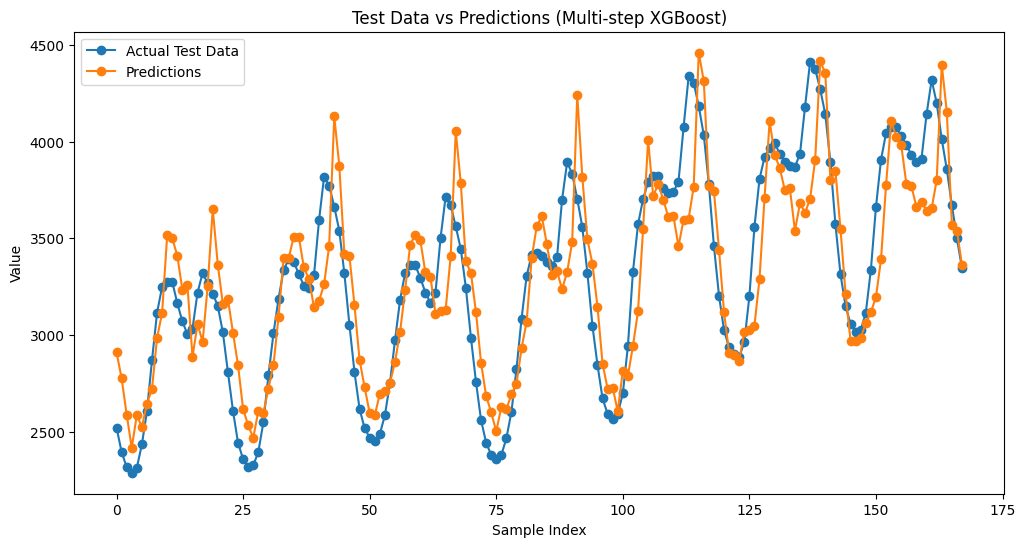

In [92]:
model_lr_multi = LinearRegression()
model_lr_multi.fit(X_train, y_train)

predictions_multi_lr = model_lr_multi.predict(X_test)
mse_multi_lr = mean_squared_error(y_test, predictions_multi_lr)
print(f'Mean Squared Error (Multi Step - Regressão Linear): {mse_multi_lr}')


#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o' )
plt.plot(predictions_multi_lr[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Regresão Linear, lag=5)')
plt.legend()
plt.show()



Mean Squared Error (Multi-Step - XGBoost): 38447.06343126951


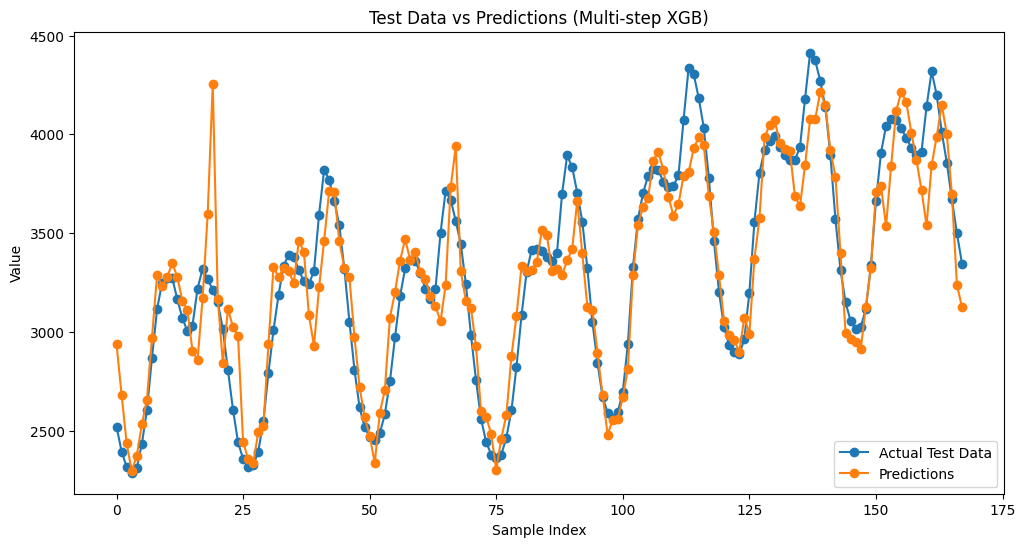

In [94]:
model_xgb_multi = XGBRegressor()

model_xgb_multi.fit(X_train, y_train)

predictions_multi_xgb = model_xgb_multi.predict(X_test)


mse_multi_step_xgb = mean_squared_error(y_test, predictions_multi_xgb)
print(f"Mean Squared Error (Multi-Step - XGBoost): {mse_multi_step_xgb}")

#ploting xgb
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o' )
plt.plot(predictions_multi_xgb[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (XGBoost, lag=5)')
plt.legend()
plt.show()



Mean Squared Error (Multi-Step - Gradient Boosting): 38447.06343126951


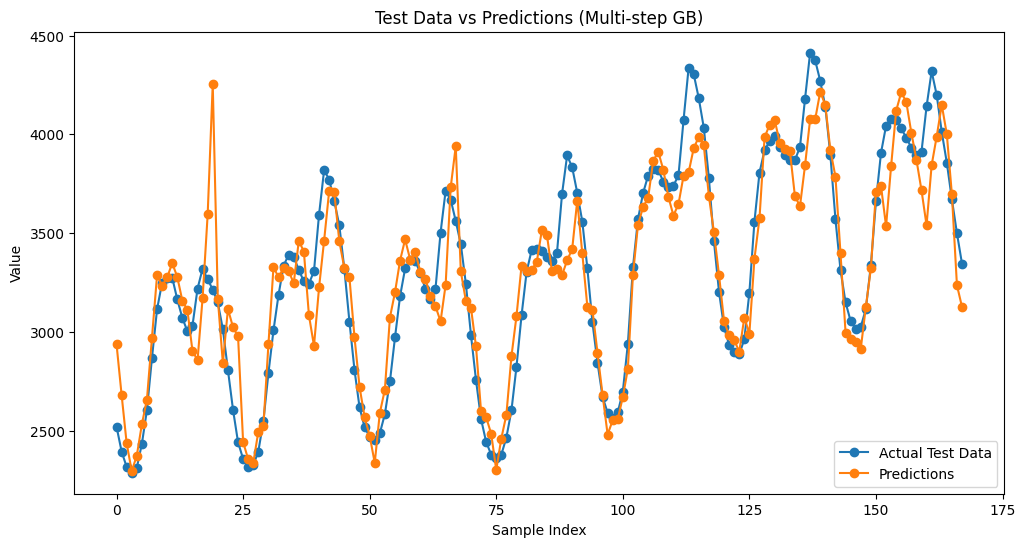

In [95]:


model_gboost = GradientBoostingRegressor()
model_gboost.fit(X_train, y_train)

predictions_multi_gboost = model_xgb_multi.predict(X_test)


mse_multi_step_gboost = mean_squared_error(y_test, predictions_multi_gboost)
print(f"Mean Squared Error (Multi-Step - Gradient Boosting): {mse_multi_step_gboost}")

#ploting GB
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o' )
plt.plot(predictions_multi_gboost[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Gradient Boost, lag=5)')
plt.legend()
plt.show()

Mean Squared Error (Multi-Step - Random Forest): 35891.10824272918


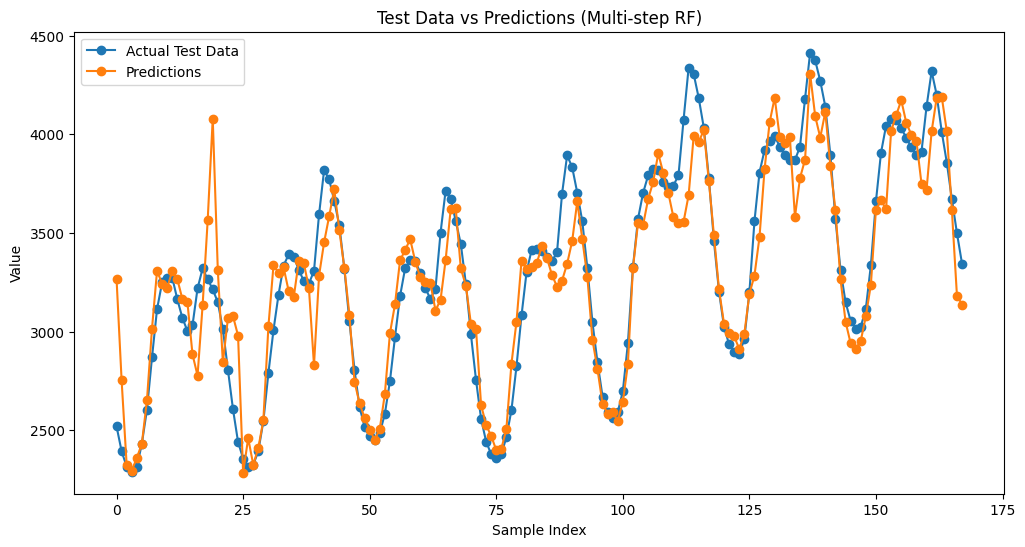

In [96]:

model_rf_multi = RandomForestRegressor()
model_rf_multi.fit(X_train, y_train)

predictions_multi_step_rf = model_rf_multi.predict(X_test)


mse_multi_step_rf = mean_squared_error(y_test, predictions_multi_step_rf)
print(f"Mean Squared Error (Multi-Step - Random Forest): {mse_multi_step_rf}")

#ploting GB
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o' )
plt.plot(predictions_multi_step_rf[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Random Forest, lag=5)')
plt.legend()
plt.show()


Epoch 1/50
526/526 [==============================] - 3s 3ms/step - loss: 445699.0000 - val_loss: 180921.2500
Epoch 2/50
526/526 [==============================] - 1s 3ms/step - loss: 171601.7031 - val_loss: 142816.4844
Epoch 3/50
526/526 [==============================] - 1s 3ms/step - loss: 145150.7656 - val_loss: 133152.0625
Epoch 4/50
526/526 [==============================] - 1s 2ms/step - loss: 133505.3750 - val_loss: 119718.1484
Epoch 5/50
526/526 [==============================] - 2s 3ms/step - loss: 130413.3047 - val_loss: 116772.5156
Epoch 6/50
526/526 [==============================] - 1s 2ms/step - loss: 125310.4062 - val_loss: 114277.9844
Epoch 7/50
526/526 [==============================] - 2s 4ms/step - loss: 123037.6172 - val_loss: 106517.6797
Epoch 8/50
526/526 [==============================] - 2s 4ms/step - loss: 118642.0156 - val_loss: 113350.0469
Epoch 9/50
526/526 [==============================] - 2s 4ms/step - loss: 114759.0234 - val_loss: 102406.4375
Epoch 10/5

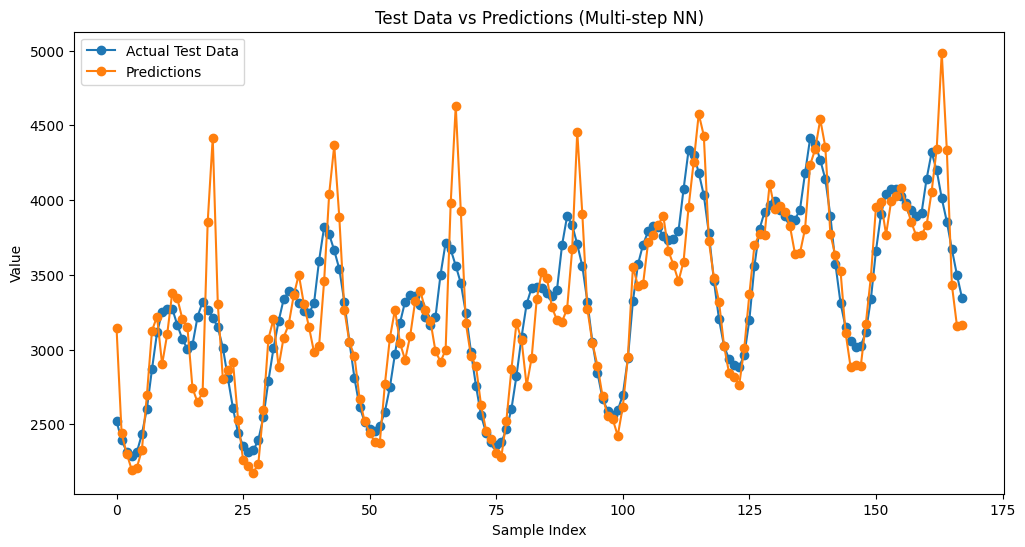

In [97]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred_multi_NN = model.predict(X_test).flatten()

mse_multi_NN = mean_squared_error(y_test, y_pred_multi_NN)
print(f'Mean Squared Error on Multi Step Neural Network: {mse_multi_NN}')

#ploting NN
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o' )
plt.plot(y_pred_multi_NN[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Neural Networks, lag=5)')
plt.legend()
plt.show()


# Deep Learning

In [39]:
from sklearn.feature_selection import SequentialFeatureSelector


def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]

        X.append(row)
        label = df_as_np[i+5]

        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(df['load'], 5)
X, y = df_to_X_y(df['load'], 6)

split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train, y_train = X[:split_train_index], y[:split_train_index]
X_val, y_val = X[split_train_index:split_val_index], y[split_train_index:split_val_index]
X_test, y_test = X[split_val_index:], y[split_val_index:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=50, batch_size=32, verbose=1)

predictions_single_lstm = model_lstm.predict(X_test)

mse_single_lstm = mean_squared_error(y_test, predictions_single_lstm)



def df_to_X_y_multi(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        row = [[a] for a in df_as_np[i:i+window_size]]

        X.append(row)
        labels = df_as_np[i+window_size:i+window_size+horizon]

        y.append(labels)
    return np.array(X), np.array(y)

X_multi, y_multi = df_to_X_y_multi(df['load'], window_size=5, horizon=3)

split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train_multi, y_train_multi = X_multi[:split_train_index], y_multi[:split_train_index]
X_val_multi, y_val_multi = X_multi[split_train_index:split_val_index], y_multi[split_train_index:split_val_index]
X_test_multi, y_test_multi = X_multi[split_val_index:], y_multi[split_val_index:]

print(X_train_multi.shape, y_train_multi.shape)
print(X_val_multi.shape, y_val_multi.shape)
print(X_test_multi.shape, y_test_multi.shape)

model_lstm_multi = Sequential()
model_lstm_multi.add(LSTM(50, activation='relu', input_shape=(X_train_multi.shape[1], 1)))
model_lstm_multi.add(Dense(3))  # Assuming horizon=3
model_lstm_multi.compile(optimizer='adam', loss='mse')

model_lstm_multi.fit(X_train_multi, y_train_multi, validation_data=(X_val_multi, y_val_multi), epochs=50, batch_size=32, verbose=1)

predictions_multi_lstm = model_lstm_multi.predict(X_test_multi)

mse_multi_lstm = mean_squared_error(y_test_multi.reshape(-1, 1), predictions_multi_lstm.reshape(-1, 1))



(18410, 5, 1) (18410,)
(2630, 5, 1) (2630,)
(5254, 5, 1) (5254,)
Epoch 1/50
576/576 [==============================] - 6s 7ms/step - loss: 579311.6250 - val_loss: 57456.8633
Epoch 2/50
576/576 [==============================] - 4s 6ms/step - loss: 93844.8203 - val_loss: 160798.5000
Epoch 3/50
576/576 [==============================] - 4s 6ms/step - loss: 167429.4844 - val_loss: 72055.5703
Epoch 4/50
576/576 [==============================] - 3s 5ms/step - loss: 111105.2422 - val_loss: 74995.1797
Epoch 5/50
576/576 [==============================] - 3s 5ms/step - loss: 108122.8750 - val_loss: 93031.1641
Epoch 6/50
576/576 [==============================] - 5s 9ms/step - loss: 87247.8672 - val_loss: 58988.9766
Epoch 7/50
576/576 [==============================] - 4s 6ms/step - loss: 76619.3438 - val_loss: 54802.1055
Epoch 8/50
576/576 [==============================] - 3s 5ms/step - loss: 61572.8594 - val_loss: 45546.4570
Epoch 9/50
576/576 [==============================] - 3s 6ms/step 

In [40]:
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)
predictions_single_gru = model_gru.predict(X_test)
mse_single_gru = mean_squared_error(y_test, predictions_single_gru)

def df_to_X_y_multi(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        
        labels = df_as_np[i+window_size:i+window_size+horizon]
        y.append(labels)
    
    return np.array(X), np.array(y)

# Modificar a chamada da função para incluir o tamanho da janela e o horizonte desejados
X_multi, y_multi = df_to_X_y_multi(df['load'], window_size=5, horizon=3)

# Divisão em treino, validação e teste
split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train_multi, y_train_multi = X_multi[:split_train_index], y_multi[:split_train_index]
X_val_multi, y_val_multi = X_multi[split_train_index:split_val_index], y_multi[split_train_index:split_val_index]
X_test_multi, y_test_multi = X_multi[split_val_index:], y_multi[split_val_index:]

print(X_train_multi.shape, y_train_multi.shape)
print(X_val_multi.shape, y_val_multi.shape)
print(X_test_multi.shape, y_test_multi.shape)

# Construir o modelo GRU para previsão de vários passos
model_gru_multi = Sequential()
model_gru_multi.add(GRU(50, activation='relu', input_shape=(X_train_multi.shape[1], 1)))
model_gru_multi.add(Dense(3))  # Supondo horizon=3
model_gru_multi.compile(optimizer='adam', loss='mse')

# Treinar o modelo GRU para previsão de vários passos
model_gru_multi.fit(X_train_multi, y_train_multi, validation_data=(X_val_multi, y_val_multi), epochs=50, batch_size=32, verbose=1)

# Previsão de vários passos
predictions_multi_gru = model_gru_multi.predict(X_test_multi)

mse_multi_gru = mean_squared_error(y_test_multi.reshape(-1, 1), predictions_multi_gru.reshape(-1, 1))


Epoch 1/50
576/576 [==============================] - 6s 6ms/step - loss: 573837.3750 - val_loss: 59552.5000
Epoch 2/50
576/576 [==============================] - 3s 5ms/step - loss: 65608.9688 - val_loss: 47092.2578
Epoch 3/50
576/576 [==============================] - 3s 5ms/step - loss: 50107.3008 - val_loss: 35718.0664
Epoch 4/50
576/576 [==============================] - 3s 5ms/step - loss: 36647.6562 - val_loss: 26406.9258
Epoch 5/50
576/576 [==============================] - 3s 5ms/step - loss: 25343.6641 - val_loss: 19882.8438
Epoch 6/50
576/576 [==============================] - 3s 5ms/step - loss: 19486.2637 - val_loss: 15674.2207
Epoch 7/50
576/576 [==============================] - 3s 6ms/step - loss: 15687.2344 - val_loss: 12540.9844
Epoch 8/50
576/576 [==============================] - 3s 5ms/step - loss: 13520.3848 - val_loss: 11611.9346
Epoch 9/50
576/576 [==============================] - 3s 5ms/step - loss: 12278.7109 - val_loss: 10596.0205
Epoch 10/50
576/576 [======

In [98]:
df_last_week = df.tail(7 * 24)  # 7 dias * 24 horas por dia
historical_means_by_hour = df_last_week.groupby(df_last_week.index.hour)['load'].mean()
predictions_baseline_by_hour = historical_means_by_hour[df_last_week.index.hour].values
mse_baseline_by_hour = mean_squared_error(df_last_week['load'], predictions_baseline_by_hour)

print(f'Mean Squared Error (Baseline por Hora - Última Semana): {mse_baseline_by_hour}')

Mean Squared Error (Baseline por Hora - Última Semana): 106054.83673469388


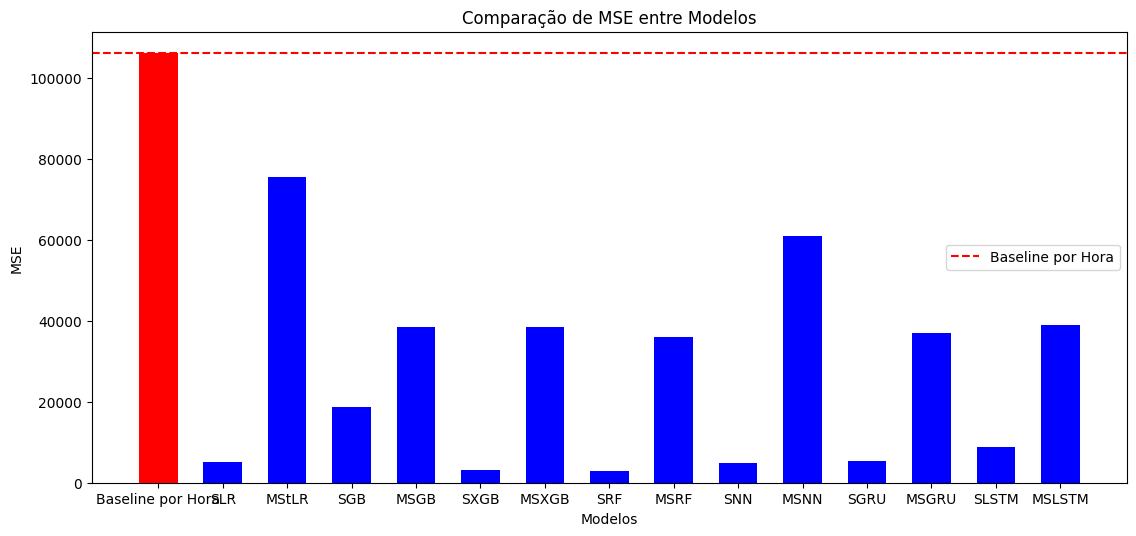

In [99]:
plt.figure(figsize=(12, 6))

# Adicionar barras para os valores de MSE
plt.bar(
    ["Baseline por Hora","SARIMA","SARIMAX" "SLR", "MStLR", "SGB", "MSGB", "SXGB", "MSXGB", "SRF", "MSRF", "SNN", "MSNN", "SGRU", "MSGRU", "SLSTM", "MSLSTM"],
    [
        mse_baseline_by_hour,
        mse_sarima,
        mse_sarimax_exog,
        mse_single_lr,
        mse_multi_lr,
        mse_single_gboost,
        mse_multi_step_gboost,
        mse_single_xgb,
        mse_multi_step_xgb,
        mse_single_rf,
        mse_multi_step_rf,
        mse_single_nn,
        mse_multi_NN,
        mse_single_gru,
        mse_multi_gru,
        mse_single_lstm,
        mse_multi_lstm,
    ],
    color=["red"] + ["blue"] * 14,
    width=0.6  # Ajuste o valor conforme necessário
)

# Adicionar uma linha horizontal tracejada para o valor do primeiro modelo (Baseline por Hora)
plt.axhline(
    y=mse_baseline_by_hour, color="red", linestyle="--", label="Baseline por Hora"
)

# Configurar título e rótulos dos eixos
plt.title("Comparação de MSE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MSE")

# Adicionar legenda
plt.legend()

# Ajustar layout para aumentar o espaço entre as barras e as legendas
plt.tight_layout(pad=3.0)  # Ajuste o valor de 'pad' conforme necessário

# Mostrar o gráfico
plt.show()
